# Modeling - NBA Draft Prediction Project
In this notebook, we build and evaluate a machine learning model to predict which NCAA players will become NBA All-Stars. A Random Forest classifier is used due to its robustness and interpretability.

# 04 Modeling

In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [125]:
df = pd.read_csv('../data/processed/merged_data.csv')
df['Weight (lbs)'] = df['Weight (lbs)'].replace('-', np.nan)
train_df = df.query("`Draft Year` <= 2019") # Filter out the new/undeveloped players

## Train-Test Split
We begin by splitting the data into training and test sets. The target variable is the binary `all_star` label.

In [141]:
X = train_df.drop('All-Star', axis=1)
y = train_df['All-Star'].map({'Yes': 1, 'No': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47, stratify=y)
train_names = X_train['Player']
test_names = X_test['Player']
X_train = X_train.drop(['Player', 'Draft Year', 'Team'], axis=1) # Get rid of qualitative columns
X_test = X_test.drop(['Player', 'Draft Year', 'Team'], axis=1)

## Model Training - Random Forest Classifier
We train a Random Forest classifier, which performs well with tabular data and provides feature importance insights.

In [127]:
model = RandomForestClassifier(random_state=47)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print (accuracy_score(y_test, predicted))

0.9301470588235294


Since there is a class imbalance, accuracy doesn't mean much because classifying every player as 'No' for all-star status would lead to an accuracy like this

## Model Evaluation
We evaluate the model using accuracy, precision, recall, and ROC-AUC score. This helps us understand how well the model distinguishes between All-Stars and non-All-Stars.

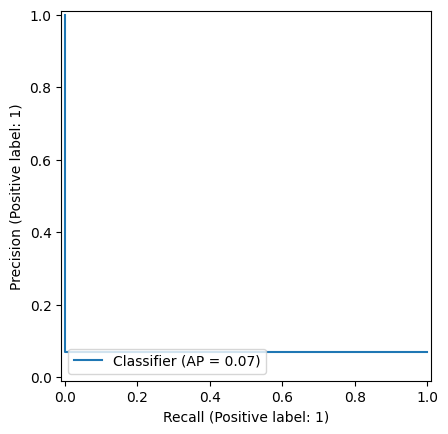

In [128]:
PrecisionRecallDisplay.from_predictions(y_test, predicted)

In [129]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       253
           1       0.00      0.00      0.00        19

    accuracy                           0.93       272
   macro avg       0.47      0.50      0.48       272
weighted avg       0.87      0.93      0.90       272



/Users/jackkenzakowski/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jackkenzakowski/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jackkenzakowski/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [130]:
print(confusion_matrix(y_test, predicted))

[[253   0]
 [ 19   0]]


As we can see, the results are pretty abysmal. As feared, none of the players were classified as All-Stars and that is what contributed to the accuracy of 0.93

## Model Adjustments

In [131]:
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=47)

model.fit(X_train, y_train)
 
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       253
           1       0.00      0.00      0.00        19

    accuracy                           0.93       272
   macro avg       0.47      0.50      0.48       272
weighted avg       0.87      0.93      0.90       272

[[253   0]
 [ 19   0]]


/Users/jackkenzakowski/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jackkenzakowski/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jackkenzakowski/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Unfortunately, this one hyperparameter change didn't fix our results, so we need to focus on more complex methods. Our focus should be on false negatives, because we don't wanna pass up on a would-be all-star.

In [132]:
param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
}

model = RandomForestClassifier(random_state=47,
                              criterion='gini',
                               n_estimators=30,
                              class_weight='balanced')

CV_model = GridSearchCV(estimator=model, param_grid=param_grid, 
                        cv=5, scoring='f1', n_jobs=-1)

CV_model.fit(X_train, y_train)
CV_model.best_params_

{'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 12}

In [142]:
model = RandomForestClassifier(random_state=47,
                              criterion='gini',
                              n_estimators=30,
                              class_weight='balanced',
                              max_depth=80,
                              max_features='sqrt',
                              min_samples_leaf=3,
                              min_samples_split=12)
model.fit(X_train, y_train)

predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       253
           1       0.50      0.05      0.10        19

    accuracy                           0.93       272
   macro avg       0.72      0.52      0.53       272
weighted avg       0.90      0.93      0.90       272

[[252   1]
 [ 18   1]]


## All-Star Predictions (2020–2024)
We apply the model to recent players and output the probability that each becomes an NBA All-Star.

In [143]:
training_results = pd.DataFrame({
    'Player': train_names,
    'Probability': model.predict_proba(X_train)[:,1].round(2),
    'Actual': y_train
}).sort_values(by='Probability', ascending=False)

training_results.to_csv('../results/training_results.csv', index=False)

In [144]:
test_results = pd.DataFrame({
    'Player': test_names,
    'Probability': probs[:,1].round(2),
    'Actual': y_test
}).sort_values(by='Probability', ascending=False)

test_results.to_csv('../results/test_results.csv', index=False)

## Results

In [148]:
test_df = df.query("`Draft Year` >= 2020")
X_newtest = test_df.drop(['Player', 'Draft Year', 'Team', 'All-Star'], axis=1)
y_pred = model.predict(X_newtest)
y_prob = model.predict_proba(X_newtest)[:,1]
results = pd.DataFrame({'Player': test_df['Player'], 'Probability': y_prob.round(2), 'Prediction': y_pred}).sort_values(by='Probability', ascending=False)
allstar_results = results.query('Prediction == 1')

In [149]:
allstar_results

,Player,Probability,Prediction
1003,Jaden Ivey,0.69,1
947,Cade Cunningham,0.64,1
988,Paolo Banchero,0.54,1
1103,Zach Edey,0.52,1
1050,Keyonte George,0.50,1


In [150]:
results.to_csv('../results/results.csv', index=False)
allstar_results.to_csv('../results/allstars.csv', index=False)